# Automated Machine Learning
_**Classification with Deployment using a Las Vegas Trip Advisor Dataset**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Train](#Train)
1. [Results](#Results)
1. [Deploy](#Deploy)
1. [Test](#Test)
1. [Acknowledgements](#Acknowledgements)

## Introduction

In this example we use the UCI Las Vegas Trip Advisor dataset to showcase how you can use AutoML for a  classification problem and deploy it to an Azure Container Instance (ACI). The Las Vegas TripAdvisor dataset contained various metrics about the features available at the hotel, the type and location of customer, TripAdvisor membership duration, period of stay, and a Score between 1 and 5 from each of the reviewers. The objective of the project is to make a recommendation to a potential customer on whether or not the hotel should be chosen. The Classification model would return "Yes" if the Score is equal to and greater than 3 and "No" otherwise.

## Setup

Create an Azure ML `Workspace` object, `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.interpret import ExplanationClient

SDK Version #.

In [2]:
# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.19.0


**Azure ML Workspace Authentication**

In [3]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

# choose a name for experiment
experiment_name = 'lv-automl-classification'

experiment=Experiment(ws, experiment_name)

quick-starts-ws-132714
aml-quickstarts-132714
southcentralus
610d6e37-4747-4a20-80eb-3aad70a55f43


## Create or Attach existing AmlCompute
You will need to create a compute target for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.
#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "automl-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Data

### Load Data

Load Las Vegas Trip Advisor dataset as a Tabular Dataset from Github link.

### Training Data

In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/Kbhamidipa3/udacityazure_capstone_final/main/LV_github_automl_train.csv")
data.head()

,Casino,Free_internet,Gym,Helpful_votes,Hotel_name,Hotel_stars,Member_years,Nr_hotel_reviews,Nr_reviews,Nr_rooms,Period_of_stay,Pool,Review_month,Review_weekday,Score,Spa,Tennis_court,Traveler_type,User_continent,User_country
0,YES,YES,YES,46,Tuscany Las Vegas Suites & Casino,3,1,20,119,716,Jun-Aug,YES,June,Sunday,1,YES,YES,Friends,Asia,Malaysia
1,YES,YES,YES,93,The Palazzo Resort Hotel Casino,5,8,19,75,3025,Jun-Aug,YES,August,Sunday,1,YES,NO,Friends,Europe,UK
2,YES,YES,YES,18,The Cosmopolitan Las Vegas,5,3,5,15,2959,Jun-Aug,YES,June,Wednesday,1,YES,NO,Friends,Europe,Ireland
3,YES,YES,YES,15,Encore at wynn Las Vegas,5,6,11,29,2034,Sep-Nov,YES,September,Monday,1,YES,NO,Couples,North America,USA
4,YES,YES,YES,4,Caesars Palace,5,3,5,5,3348,Mar-May,YES,April,Thursday,1,YES,NO,Couples,North America,Canada


In [6]:
if not os.path.isdir('data'):
    os.mkdir('data')
    
# Save the train data to a csv to be uploaded to the datastore
pd.DataFrame(data).to_csv("data/train_data.csv", index=False)

ds = ws.get_default_datastore()
ds.upload(src_dir='./data', target_path='lv-data', overwrite=True, show_progress=True)

 

# Upload the training data as a tabular dataset for access during training on remote compute
train_data = Dataset.Tabular.from_delimited_files(path=ds.path('lv-data/train_data.csv'))
label = "Score"

Uploading an estimated of 1 files
Uploading ./data/train_data.csv
Uploaded ./data/train_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files


### Validation Data

In [7]:
validation_data = "https://raw.githubusercontent.com/Kbhamidipa3/udacityazure_capstone_final/main/LV_github_automl_validation.csv"
validation_dataset = Dataset.Tabular.from_delimited_files(validation_data)

### Test Data

In [8]:
test_data = "https://raw.githubusercontent.com/Kbhamidipa3/udacityazure_capstone_final/main/LV_github_automl_test.csv"
test_dataset = Dataset.Tabular.from_delimited_files(test_data)

## Train

Instantiate AutoMLConfig object. 

|Property|Description|
|-|-|
|**task**|classification or regression or forecasting|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**blocked_models** | *List* of *strings* indicating machine learning algorithms for AutoML to avoid in this run. <br><br> Allowed values for **Classification**<br><i>LogisticRegression</i><br><i>SGD</i><br><i>MultinomialNaiveBayes</i><br><i>BernoulliNaiveBayes</i><br><i>SVM</i><br><i>LinearSVM</i><br><i>KNN</i><br><i>DecisionTree</i><br><i>RandomForest</i><br><i>ExtremeRandomTrees</i><br><i>LightGBM</i><br><i>GradientBoosting</i><br><i>TensorFlowDNN</i><br><i>TensorFlowLinearClassifier</i><br><br>Allowed values for **Regression**<br><i>ElasticNet</i><br><i>GradientBoosting</i><br><i>DecisionTree</i><br><i>KNN</i><br><i>LassoLars</i><br><i>SGD</i><br><i>RandomForest</i><br><i>ExtremeRandomTrees</i><br><i>LightGBM</i><br><i>TensorFlowLinearRegressor</i><br><i>TensorFlowDNN</i><br><br>Allowed values for **Forecasting**<br><i>ElasticNet</i><br><i>GradientBoosting</i><br><i>DecisionTree</i><br><i>KNN</i><br><i>LassoLars</i><br><i>SGD</i><br><i>RandomForest</i><br><i>ExtremeRandomTrees</i><br><i>LightGBM</i><br><i>TensorFlowLinearRegressor</i><br><i>TensorFlowDNN</i><br><i>Arima</i><br><i>Prophet</i>|
|**allowed_models** |  *List* of *strings* indicating machine learning algorithms for AutoML to use in this run. Same values listed above for **blocked_models** allowed for **allowed_models**.|
|**experiment_exit_score**| Value indicating the target for *primary_metric*. <br>Once the target is surpassed the run terminates.|
|**experiment_timeout_hours**| Maximum amount of time in hours that all iterations combined can take before the experiment terminates.|
|**enable_early_stopping**| Flag to enble early termination if the score is not improving in the short term.|
|**featurization**| 'auto' / 'off'  Indicator for whether featurization step should be done automatically or not. Note: If the input data is sparse, featurization cannot be turned on.|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|

**_For more information_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

In [9]:
automl_settings = {
    "experiment_timeout_hours" : 0.3,
    "enable_early_stopping" : True,
    "iteration_timeout_minutes": 5,
    "max_concurrent_iterations": 4,
    "max_cores_per_iteration": -1,
    #"n_cross_validations": 2,
    "primary_metric": 'accuracy',
    "featurization": 'auto',
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target=compute_target,
                             enable_onnx_compatible_models=True,
                             training_data = train_data,
                             label_column_name = label,
                             validation_data = validation_dataset,
                             **automl_settings
                            )

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while. Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [10]:
remote_run = experiment.submit(automl_config, show_output = True)

Running on remote.
No run_configuration provided, running on automl-cluster with default configuration
Running on remote compute: automl-cluster
Parent Run ID: AutoML_4c6051e3-9bda-4af2-8c76-f76fa2caf4ab

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetBalancing. Performing class balancing sweeping
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias towards one class.
+---------------------------------+---------------------------------+------

In [11]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
lv-automl-classification,AutoML_4c6051e3-9bda-4af2-8c76-f76fa2caf4ab,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [12]:
# Wait for the remote run to complete
remote_run.wait_for_completion()

{'runId': 'AutoML_4c6051e3-9bda-4af2-8c76-f76fa2caf4ab',
 'target': 'automl-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-01-01T05:55:47.682193Z',
 'endTimeUtc': '2021-01-01T06:12:58.604574Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'automl-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"lv-automl-classification","subscription_id":"610d6e37-4747-4a20-80eb-3aad70a55f43","resource_group":"aml-quickstarts-132714","workspace_name":"quick-starts-ws-132714","region":"southcentralus","compute_target":"automl-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"accuracy","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":null,"y_min":null,"y_max":nu

In [13]:
best_run_customized, fitted_model_customized = remote_run.get_output()

## Transparency

View updated featurization summary

In [14]:
custom_featurizer = fitted_model_customized.named_steps['datatransformer']
df = custom_featurizer.get_featurization_summary()
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Casino,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]
1,Free_internet,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]
2,Gym,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]
3,Hotel_stars,Categorical,No,3,[StringCast-CharGramCountVectorizer]
4,Member_years,Categorical,No,13,[StringCast-CharGramCountVectorizer]
5,Period_of_stay,Categorical,No,4,[StringCast-CharGramCountVectorizer]
6,Pool,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]
7,Review_month,Categorical,No,12,[StringCast-CharGramCountVectorizer]
8,Review_weekday,Categorical,No,7,[StringCast-CharGramCountVectorizer]
9,Spa,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder]


Set `is_user_friendly=False` to get a more detailed summary for the transforms being applied.

In [15]:
df = custom_featurizer.get_featurization_summary(is_user_friendly=False)
pd.DataFrame(data=df)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations,TransformationParams
0,Casino,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],"{'Transformer1': {'Input': ['Casino'], 'Transf..."
1,Free_internet,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],"{'Transformer1': {'Input': ['Free_internet'], ..."
2,Gym,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],"{'Transformer1': {'Input': ['Gym'], 'Transform..."
3,Hotel_stars,Categorical,No,3,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Hotel_stars'], 'T..."
4,Member_years,Categorical,No,13,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Member_years'], '..."
5,Period_of_stay,Categorical,No,4,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Period_of_stay'],..."
6,Pool,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],"{'Transformer1': {'Input': ['Pool'], 'Transfor..."
7,Review_month,Categorical,No,12,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Review_month'], '..."
8,Review_weekday,Categorical,No,7,[StringCast-CharGramCountVectorizer],"{'Transformer1': {'Input': ['Review_weekday'],..."
9,Spa,Categorical,No,1,[ModeCatImputer-StringCast-LabelEncoder],"{'Transformer1': {'Input': ['Spa'], 'Transform..."


In [16]:
df = custom_featurizer.get_stats_feature_type_summary()
pd.DataFrame(data=df)

""


## Results

In [17]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### Retrieve the Best Model's explanation
Retrieve the explanation from the best_run which includes explanations for engineered features and raw features. 

In [18]:
# Wait for the best model explanation run to complete
from azureml.core.run import Run
model_explainability_run_id = remote_run.id + "_" + "ModelExplain"
print(model_explainability_run_id)
model_explainability_run = Run(experiment=experiment, run_id=model_explainability_run_id)
model_explainability_run.wait_for_completion()

# Get the best run object
best_run, fitted_model = remote_run.get_output()

AutoML_4c6051e3-9bda-4af2-8c76-f76fa2caf4ab_ModelExplain


#### Download engineered feature importance from artifact store
You can use ExplanationClient to download the engineered feature explanations from the artifact store of the best_run.

In [19]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'Nr_hotel_reviews_MeanImputer': 0.5252336793099083,
 'Nr_reviews_MeanImputer': 0.3008865330922028,
 'Nr_rooms_MeanImputer': 0.28139142678299484,
 'Member_years_CharGramCountVectorizer_1': 0.26803270895091985,
 'Helpful_votes_MeanImputer': 0.24656906263048575,
 'Hotel_name_HashOneHotEncoder_6': 0.24603089381146373,
 'Traveler_type_CharGramCountVectorizer_Couples': 0.15015814213345421,
 'Review_weekday_CharGramCountVectorizer_Tuesday': 0.09201815519353909,
 'User_country_HashOneHotEncoder_6': 0.06810980621539205,
 'Hotel_name_HashOneHotEncoder_5': 0.05320152262294776,
 'User_continent_CharGramCountVectorizer_Europe': 0.0512411473049951,
 'Spa_ModeCatImputer_LabelEncoder': 0.05075028738976062,
 'Hotel_stars_CharGramCountVectorizer_5': 0.04677114769384054,
 'Review_weekday_CharGramCountVectorizer_Wednesday': 0.03675950183303024,
 'Review_month_CharGramCountVectorizer_August': 0.03366478980101488,
 'Review_month_CharGramCountVectorizer_February': 0.03112117313500937,
 'Traveler_type_CharGr

#### Download raw feature importance from artifact store
ExplanationClient is used to download the raw feature explanations from the artifact store of the best_run.

In [20]:
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=True)
exp_data = engineered_explanations.get_feature_importance_dict()
exp_data

{'Nr_hotel_reviews': 0.5252336793099083,
 'Hotel_name': 0.3347110500485032,
 'Member_years': 0.3209379932456903,
 'Nr_reviews': 0.3008865330922028,
 'Nr_rooms': 0.28139142678299484,
 'Helpful_votes': 0.24656906263048575,
 'Traveler_type': 0.19250070012905443,
 'Review_weekday': 0.17930412085405328,
 'Review_month': 0.11726498501161636,
 'User_country': 0.0938802168380625,
 'Hotel_stars': 0.08745503761455037,
 'User_continent': 0.0705285864527643,
 'Period_of_stay': 0.05796950973275003,
 'Spa': 0.05075028738976062,
 'Tennis_court': 0.024384040833106194,
 'Casino': 0.014603106105591224,
 'Gym': 0.0035345485189214316,
 'Pool': 0.0,
 'Free_internet': 0.0}

## Deploy

### Retrieve the Best Model


#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [21]:
best_run, fitted_model = remote_run.get_output()

In [22]:
model_name = best_run.properties['model_name']

script_file_name = 'inference/score.py'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'inference/score.py')

### Register the Fitted Model for Deployment
If neither `metric` nor `iteration` are specified in the `register_model` call, the iteration with the best primary metric is registered.

In [23]:
description = 'AutoML Model trained on LV hotel trip advisor data to predict if a hotel can be recommended or not'
tags = None
model = remote_run.register_model(model_name = model_name, description = description, tags = tags)

print(remote_run.model_id) # This will be written to the script file later in the notebook.

AutoML4c6051e396


### Deploy the model as a Web Service on Azure Container Instance

In [26]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

inference_config = InferenceConfig(entry_script=script_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "lvData", 'type': "automl_classification"}, 
                                               description = 'service for LV hotel Automl Classification',
                                               auth_enabled=True,
                                               enable_app_insights=True)

aci_service_name = 'automl-sample-lvhotel-all'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-sample-lvhotel-all
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


### Get Logs from a Deployed Web Service

Gets logs from a deployed web service.

In [27]:
aci_service.get_logs()

'2021-01-01T06:30:36,219625779+00:00 - rsyslog/run \n2021-01-01T06:30:36,219642979+00:00 - gunicorn/run \n2021-01-01T06:30:36,220400185+00:00 - iot-server/run \n2021-01-01T06:30:36,395716390+00:00 - nginx/run \n/usr/sbin/nginx: /azureml-envs/azureml_8eff28b157f42edcd2424a5aae6c8074/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_8eff28b157f42edcd2424a5aae6c8074/lib/libcrypto.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_8eff28b157f42edcd2424a5aae6c8074/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_8eff28b157f42edcd2424a5aae6c8074/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)\n/usr/sbin/nginx: /azureml-envs/azureml_8eff28b157f42edcd2424a5aae6c8074/lib/libssl.so.1.0.0: no version information available (required by /usr/sbin/nginx)

## Test

Now that the model is trained, run the test data through the trained model to get the predicted values.  This calls the ACI web service to do the prediction.

Note that the JSON passed to the ACI web service is an array of rows of data.  Each row should either be an array of values in the same order that was used for training or a dictionary where the keys are the same as the column names used for training.  The example below uses dictionary rows.

In [28]:
# Load the lV TripAdvisor datasets.
from numpy import array

In [29]:
X_test = test_dataset.drop_columns(columns=['Score'])
y_test = test_dataset.keep_columns(columns=['Score'], validate=True)
test_dataset.take(5).to_pandas_dataframe()

,Casino,Free_internet,Gym,Helpful_votes,Hotel_name,Hotel_stars,Member_years,Nr_hotel_reviews,Nr_reviews,Nr_rooms,Period_of_stay,Pool,Review_month,Review_weekday,Score,Spa,Tennis_court,Traveler_type,User_continent,User_country
0,True,True,True,80,The Palazzo Resort Hotel Casino,5,8,30,36,3025,Mar-May,True,March,Friday,1,True,False,Families,North America,Canada
1,True,True,True,30,Encore at wynn Las Vegas,5,2,12,28,2034,Jun-Aug,True,June,Saturday,1,True,False,Couples,Europe,UK
2,True,True,True,18,The Westin las Vegas Hotel Casino & Spa,4,3,10,17,826,Mar-May,True,May,Tuesday,1,True,False,Couples,North America,USA
3,True,True,True,14,Treasure Island- TI Hotel & Casino,4,6,11,29,2884,Dec-Feb,True,January,Sunday,1,True,True,Business,Europe,Croatia
4,True,True,True,14,Hilton Grand Vacations on the Boulevard,3,1,17,28,1228,Sep-Nov,True,October,Sunday,1,True,False,Solo,North America,USA


In [ ]:
X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()

In [59]:
import requests
import json

# URL for the web service
scoring_uri = 'http://5811af68-7ac4-4211-877a-afd94fe91b7c.southcentralus.azurecontainer.io/score'
# If the service is authenticated, set the key or token
key = 'SuJqEk5P8RHDjz6nYDhFSj1eJ8CnEPTh'

# Two sets of data to score, so we get two results back
data = {"data": [{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":80,"Hotel_name":"The Palazzo Resort Hotel Casino","Hotel_stars":5,"Member_years":8,"Nr_hotel_reviews":30,"Nr_reviews":36,"Nr_rooms":3025,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"March","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":30,"Hotel_name":"Encore at wynn Las Vegas","Hotel_stars":5,"Member_years":2,"Nr_hotel_reviews":12,"Nr_reviews":28,"Nr_rooms":2034,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"June","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":18,"Hotel_name":"The Westin las Vegas Hotel Casino & Spa","Hotel_stars":4,"Member_years":3,"Nr_hotel_reviews":10,"Nr_reviews":17,"Nr_rooms":826,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"May","Review_weekday":"Tuesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":14,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":6,"Nr_hotel_reviews":11,"Nr_reviews":29,"Nr_rooms":2884,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Business","User_continent":"Europe","User_country":"Croatia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":14,"Hotel_name":"Hilton Grand Vacations on the Boulevard","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":17,"Nr_reviews":28,"Nr_rooms":1228,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Solo","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":20,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":8,"Nr_reviews":43,"Nr_rooms":2884,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"March","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":6,"Hotel_name":"Paris Las Vegas","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":4,"Nr_reviews":6,"Nr_rooms":2916,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":43,"Hotel_name":"Caesars Palace","Hotel_stars":5,"Member_years":4,"Nr_hotel_reviews":24,"Nr_reviews":35,"Nr_rooms":3348,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"November","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":11,"Hotel_name":"Paris Las Vegas","Hotel_stars":4,"Member_years":3,"Nr_hotel_reviews":9,"Nr_reviews":22,"Nr_rooms":2916,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":25,"Hotel_name":"The Westin las Vegas Hotel Casino & Spa","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":3,"Nr_reviews":35,"Nr_rooms":826,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"Trump International Hotel Las Vegas","Hotel_stars":5,"Member_years":5,"Nr_hotel_reviews":13,"Nr_reviews":33,"Nr_rooms":1282,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"February","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":11,"Hotel_name":"Circus Circus Hotel & Casino Las Vegas","Hotel_stars":3,"Member_years":5,"Nr_hotel_reviews":7,"Nr_reviews":12,"Nr_rooms":3773,"Period_of_stay":"Mar-May","Pool":"FALSE","Review_month":"May","Review_weekday":"Tuesday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":6,"Hotel_name":"Paris Las Vegas","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":7,"Nr_reviews":24,"Nr_rooms":2916,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"December","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":7,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":9,"Nr_hotel_reviews":14,"Nr_reviews":15,"Nr_rooms":2884,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Tuesday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":6,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":5,"Nr_reviews":6,"Nr_rooms":643,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":88,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":34,"Nr_reviews":160,"Nr_rooms":643,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":10,"Hotel_name":"Caesars Palace","Hotel_stars":5,"Member_years":4,"Nr_hotel_reviews":12,"Nr_reviews":31,"Nr_rooms":3348,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"March","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"FALSE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":12,"Hotel_name":"Wyndham Grand Desert","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":3,"Nr_reviews":17,"Nr_rooms":787,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"TRUE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":15,"Hotel_name":"Wynn Las Vegas","Hotel_stars":5,"Member_years":7,"Nr_hotel_reviews":11,"Nr_reviews":18,"Nr_rooms":2700,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"February","Review_weekday":"Tuesday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":37,"Hotel_name":"Bellagio Las Vegas","Hotel_stars":5,"Member_years":6,"Nr_hotel_reviews":25,"Nr_reviews":102,"Nr_rooms":3933,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"August","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Europe","User_country":"Scotland"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":99,"Hotel_name":"Encore at wynn Las Vegas","Hotel_stars":5,"Member_years":10,"Nr_hotel_reviews":32,"Nr_reviews":73,"Nr_rooms":2034,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"South America","User_country":"Honduras"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":4,"Hotel_name":"Encore at wynn Las Vegas","Hotel_stars":5,"Member_years":1,"Nr_hotel_reviews":3,"Nr_reviews":9,"Nr_rooms":2034,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"August","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":13,"Hotel_name":"Excalibur Hotel & Casino","Hotel_stars":3,"Member_years":7,"Nr_hotel_reviews":8,"Nr_reviews":11,"Nr_rooms":3981,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"The Westin las Vegas Hotel Casino & Spa","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":4,"Nr_reviews":15,"Nr_rooms":826,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":19,"Hotel_name":"The Venetian Las Vegas Hotel","Hotel_stars":5,"Member_years":4,"Nr_hotel_reviews":6,"Nr_reviews":15,"Nr_rooms":4027,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":23,"Hotel_name":"Bellagio Las Vegas","Hotel_stars":5,"Member_years":5,"Nr_hotel_reviews":5,"Nr_reviews":28,"Nr_rooms":3933,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":16,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":6,"Nr_hotel_reviews":13,"Nr_reviews":16,"Nr_rooms":2884,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Families","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":0,"Nr_reviews":6,"Nr_rooms":643,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":31,"Hotel_name":"Wynn Las Vegas","Hotel_stars":5,"Member_years":3,"Nr_hotel_reviews":17,"Nr_reviews":142,"Nr_rooms":2700,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":3,"Hotel_name":"The Westin las Vegas Hotel Casino & Spa","Hotel_stars":4,"Member_years":5,"Nr_hotel_reviews":6,"Nr_reviews":21,"Nr_rooms":826,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"August","Review_weekday":"Tuesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":7,"Hotel_name":"The Palazzo Resort Hotel Casino","Hotel_stars":5,"Member_years":6,"Nr_hotel_reviews":3,"Nr_reviews":10,"Nr_rooms":3025,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"March","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":39,"Hotel_name":"Bellagio Las Vegas","Hotel_stars":5,"Member_years":3,"Nr_hotel_reviews":10,"Nr_reviews":17,"Nr_rooms":3933,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"November","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"North America","User_country":"Canada"},{"Casino":"FALSE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":4,"Hotel_name":"Hilton Grand Vacations at the Flamingo","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":4,"Nr_reviews":17,"Nr_rooms":315,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"August","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":5,"Hotel_name":"Tuscany Las Vegas Suites & Casino","Hotel_stars":3,"Member_years":4,"Nr_hotel_reviews":8,"Nr_reviews":9,"Nr_rooms":716,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"December","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Families","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":51,"Hotel_name":"Paris Las Vegas","Hotel_stars":4,"Member_years":5,"Nr_hotel_reviews":42,"Nr_reviews":137,"Nr_rooms":2916,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"May","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":10,"Hotel_name":"The Cosmopolitan Las Vegas","Hotel_stars":5,"Member_years":1,"Nr_hotel_reviews":8,"Nr_reviews":30,"Nr_rooms":2959,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"May","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":25,"Hotel_name":"Circus Circus Hotel & Casino Las Vegas","Hotel_stars":3,"Member_years":2,"Nr_hotel_reviews":9,"Nr_reviews":36,"Nr_rooms":3773,"Period_of_stay":"Mar-May","Pool":"FALSE","Review_month":"February","Review_weekday":"Saturday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":23,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":33,"Nr_reviews":64,"Nr_rooms":643,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Europe","User_country":"Germany"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":11,"Hotel_name":"Wynn Las Vegas","Hotel_stars":5,"Member_years":4,"Nr_hotel_reviews":7,"Nr_reviews":12,"Nr_rooms":2700,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"September","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Business","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":5,"Nr_reviews":11,"Nr_rooms":2884,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":22,"Hotel_name":"The Westin las Vegas Hotel Casino & Spa","Hotel_stars":4,"Member_years":7,"Nr_hotel_reviews":21,"Nr_reviews":23,"Nr_rooms":826,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"August","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":12,"Hotel_name":"Bellagio Las Vegas","Hotel_stars":5,"Member_years":1,"Nr_hotel_reviews":6,"Nr_reviews":13,"Nr_rooms":3933,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":17,"Hotel_name":"Wynn Las Vegas","Hotel_stars":5,"Member_years":3,"Nr_hotel_reviews":10,"Nr_reviews":30,"Nr_rooms":2700,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"FALSE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"Monte Carlo Resort&Casino","Hotel_stars":4,"Member_years":8,"Nr_hotel_reviews":5,"Nr_reviews":8,"Nr_rooms":3003,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"November","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"Hungary"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":4,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":5,"Nr_hotel_reviews":7,"Nr_reviews":12,"Nr_rooms":2884,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Families","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":7,"Hotel_name":"Hilton Grand Vacations on the Boulevard","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":6,"Nr_reviews":11,"Nr_rooms":1228,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Solo","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"Excalibur Hotel & Casino","Hotel_stars":3,"Member_years":4,"Nr_hotel_reviews":12,"Nr_reviews":13,"Nr_rooms":3981,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"May","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"Africa","User_country":"Egypt"},{"Casino":"TRUE","Free_internet":"FALSE","Gym":"TRUE","Helpful_votes":6,"Hotel_name":"Monte Carlo Resort&Casino","Hotel_stars":4,"Member_years":10,"Nr_hotel_reviews":18,"Nr_reviews":21,"Nr_rooms":3003,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"December","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"Europe","User_country":"Greece"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":23,"Hotel_name":"Paris Las Vegas","Hotel_stars":4,"Member_years":3,"Nr_hotel_reviews":15,"Nr_reviews":50,"Nr_rooms":2916,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":13,"Hotel_name":"Circus Circus Hotel & Casino Las Vegas","Hotel_stars":3,"Member_years":9,"Nr_hotel_reviews":4,"Nr_reviews":11,"Nr_rooms":3773,"Period_of_stay":"Dec-Feb","Pool":"FALSE","Review_month":"January","Review_weekday":"Thursday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":24,"Hotel_name":"Circus Circus Hotel & Casino Las Vegas","Hotel_stars":3,"Member_years":4,"Nr_hotel_reviews":9,"Nr_reviews":20,"Nr_rooms":3773,"Period_of_stay":"Jun-Aug","Pool":"FALSE","Review_month":"June","Review_weekday":"Saturday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":68,"Hotel_name":"Encore at wynn Las Vegas","Hotel_stars":5,"Member_years":5,"Nr_hotel_reviews":43,"Nr_reviews":85,"Nr_rooms":2034,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"September","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":19,"Hotel_name":"Circus Circus Hotel & Casino Las Vegas","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":7,"Nr_reviews":18,"Nr_rooms":3773,"Period_of_stay":"Dec-Feb","Pool":"FALSE","Review_month":"December","Review_weekday":"Saturday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":9,"Hotel_name":"Tropicana Las Vegas - A Double Tree by Hilton Hotel","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":4,"Nr_reviews":14,"Nr_rooms":1467,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"March","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":23,"Hotel_name":"Encore at wynn Las Vegas","Hotel_stars":5,"Member_years":7,"Nr_hotel_reviews":14,"Nr_reviews":16,"Nr_rooms":2034,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"March","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":27,"Hotel_name":"The Westin las Vegas Hotel Casino & Spa","Hotel_stars":4,"Member_years":8,"Nr_hotel_reviews":19,"Nr_reviews":25,"Nr_rooms":826,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"February","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":17,"Hotel_name":"Bellagio Las Vegas","Hotel_stars":5,"Member_years":1,"Nr_hotel_reviews":6,"Nr_reviews":15,"Nr_rooms":3933,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"May","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":1,"Hotel_name":"Hilton Grand Vacations on the Boulevard","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":3,"Nr_reviews":10,"Nr_rooms":1228,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"North America","User_country":"Mexico"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":14,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":3,"Nr_hotel_reviews":20,"Nr_reviews":21,"Nr_rooms":2884,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"FALSE","Helpful_votes":70,"Hotel_name":"The Cromwell","Hotel_stars":4,"Member_years":10,"Nr_hotel_reviews":14,"Nr_reviews":17,"Nr_rooms":188,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"FALSE","Gym":"TRUE","Helpful_votes":19,"Hotel_name":"Monte Carlo Resort&Casino","Hotel_stars":4,"Member_years":5,"Nr_hotel_reviews":12,"Nr_reviews":33,"Nr_rooms":3003,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"August","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"FALSE","Gym":"TRUE","Helpful_votes":16,"Hotel_name":"Monte Carlo Resort&Casino","Hotel_stars":4,"Member_years":5,"Nr_hotel_reviews":18,"Nr_reviews":54,"Nr_rooms":3003,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Tuesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"Africa","User_country":"South Africa"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":1,"Hotel_name":"Trump International Hotel Las Vegas","Hotel_stars":5,"Member_years":6,"Nr_hotel_reviews":8,"Nr_reviews":26,"Nr_rooms":1282,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":19,"Hotel_name":"Circus Circus Hotel & Casino Las Vegas","Hotel_stars":3,"Member_years":2,"Nr_hotel_reviews":9,"Nr_reviews":41,"Nr_rooms":3773,"Period_of_stay":"Sep-Nov","Pool":"FALSE","Review_month":"October","Review_weekday":"Tuesday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":15,"Hotel_name":"The Venetian Las Vegas Hotel","Hotel_stars":5,"Member_years":5,"Nr_hotel_reviews":16,"Nr_reviews":60,"Nr_rooms":4027,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"February","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":26,"Hotel_name":"Wynn Las Vegas","Hotel_stars":5,"Member_years":7,"Nr_hotel_reviews":12,"Nr_reviews":40,"Nr_rooms":2700,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"September","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Friends","User_continent":"North America","User_country":"Canada"},{"Casino":"FALSE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":27,"Hotel_name":"Wyndham Grand Desert","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":17,"Nr_reviews":35,"Nr_rooms":787,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":16,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":6,"Nr_hotel_reviews":17,"Nr_reviews":27,"Nr_rooms":2884,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"June","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":9,"Hotel_name":"Excalibur Hotel & Casino","Hotel_stars":3,"Member_years":2,"Nr_hotel_reviews":6,"Nr_reviews":24,"Nr_rooms":3981,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"August","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":19,"Hotel_name":"Bellagio Las Vegas","Hotel_stars":5,"Member_years":4,"Nr_hotel_reviews":18,"Nr_reviews":20,"Nr_rooms":3933,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"December","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Asia","User_country":"Malaysia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":54,"Hotel_name":"Excalibur Hotel & Casino","Hotel_stars":3,"Member_years":7,"Nr_hotel_reviews":47,"Nr_reviews":74,"Nr_rooms":3981,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"December","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":13,"Hotel_name":"The Venetian Las Vegas Hotel","Hotel_stars":5,"Member_years":2,"Nr_hotel_reviews":3,"Nr_reviews":9,"Nr_rooms":4027,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"March","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":36,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":18,"Nr_reviews":84,"Nr_rooms":643,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":14,"Hotel_name":"Tuscany Las Vegas Suites & Casino","Hotel_stars":3,"Member_years":5,"Nr_hotel_reviews":11,"Nr_reviews":19,"Nr_rooms":716,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":3,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":2,"Nr_hotel_reviews":8,"Nr_reviews":12,"Nr_rooms":2884,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"March","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Friends","User_continent":"North America","User_country":"Canada"},{"Casino":"FALSE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":16,"Hotel_name":"Wyndham Grand Desert","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":8,"Nr_reviews":27,"Nr_rooms":787,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"TRUE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":0,"Hotel_name":"Tropicana Las Vegas - A Double Tree by Hilton Hotel","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":4,"Nr_reviews":8,"Nr_rooms":1467,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"May","Review_weekday":"Tuesday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"Oceania","User_country":"New Zeland"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":4,"Hotel_name":"Wynn Las Vegas","Hotel_stars":5,"Member_years":11,"Nr_hotel_reviews":4,"Nr_reviews":5,"Nr_rooms":2700,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"June","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"FALSE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":15,"Hotel_name":"Hilton Grand Vacations at the Flamingo","Hotel_stars":3,"Member_years":5,"Nr_hotel_reviews":5,"Nr_reviews":14,"Nr_rooms":315,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"November","Review_weekday":"Thursday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"Europe","User_country":"Czech Republic"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":85,"Hotel_name":"The Westin las Vegas Hotel Casino & Spa","Hotel_stars":4,"Member_years":12,"Nr_hotel_reviews":43,"Nr_reviews":169,"Nr_rooms":826,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Solo","User_continent":"Africa","User_country":"Egypt"},{"Casino":"TRUE","Free_internet":"FALSE","Gym":"TRUE","Helpful_votes":2,"Hotel_name":"Monte Carlo Resort&Casino","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":0,"Nr_reviews":1,"Nr_rooms":3003,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"November","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"Asia","User_country":"China"},{"Casino":"FALSE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":46,"Hotel_name":"Wyndham Grand Desert","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":35,"Nr_reviews":101,"Nr_rooms":787,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"TRUE","Traveler_type":"Friends","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"FALSE","Helpful_votes":150,"Hotel_name":"The Cromwell","Hotel_stars":4,"Member_years":10,"Nr_hotel_reviews":75,"Nr_reviews":262,"Nr_rooms":188,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Europe","User_country":"UK"},{"Casino":"FALSE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":7,"Hotel_name":"Wyndham Grand Desert","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":4,"Nr_reviews":16,"Nr_rooms":787,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":9,"Hotel_name":"Hilton Grand Vacations on the Boulevard","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":16,"Nr_reviews":20,"Nr_rooms":1228,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":3,"Hotel_name":"Trump International Hotel Las Vegas","Hotel_stars":5,"Member_years":11,"Nr_hotel_reviews":3,"Nr_reviews":4,"Nr_rooms":1282,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"Europe","User_country":"Ireland"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":27,"Hotel_name":"Paris Las Vegas","Hotel_stars":4,"Member_years":2,"Nr_hotel_reviews":10,"Nr_reviews":20,"Nr_rooms":2916,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"September","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":5,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":0,"Nr_reviews":11,"Nr_rooms":643,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":2,"Nr_hotel_reviews":9,"Nr_reviews":27,"Nr_rooms":2884,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"November","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Families","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":7,"Hotel_name":"Caesars Palace","Hotel_stars":5,"Member_years":3,"Nr_hotel_reviews":7,"Nr_reviews":10,"Nr_rooms":3348,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"September","Review_weekday":"Tuesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"The Palazzo Resort Hotel Casino","Hotel_stars":5,"Member_years":1,"Nr_hotel_reviews":4,"Nr_reviews":17,"Nr_rooms":3025,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"May","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"France"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":119,"Hotel_name":"Tuscany Las Vegas Suites & Casino","Hotel_stars":3,"Member_years":8,"Nr_hotel_reviews":71,"Nr_reviews":167,"Nr_rooms":716,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":36,"Hotel_name":"Caesars Palace","Hotel_stars":5,"Member_years":9,"Nr_hotel_reviews":22,"Nr_reviews":25,"Nr_rooms":3348,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"June","Review_weekday":"Tuesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Solo","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":31,"Hotel_name":"The Westin las Vegas Hotel Casino & Spa","Hotel_stars":4,"Member_years":4,"Nr_hotel_reviews":23,"Nr_reviews":154,"Nr_rooms":826,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"November","Review_weekday":"Thursday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"FALSE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":21,"Hotel_name":"Hilton Grand Vacations at the Flamingo","Hotel_stars":3,"Member_years":9,"Nr_hotel_reviews":13,"Nr_reviews":66,"Nr_rooms":315,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"March","Review_weekday":"Friday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":4,"Hotel_name":"Caesars Palace","Hotel_stars":5,"Member_years":1,"Nr_hotel_reviews":8,"Nr_reviews":14,"Nr_rooms":3348,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":78,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":43,"Nr_reviews":159,"Nr_rooms":643,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"Mexico"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":2,"Hotel_name":"The Venetian Las Vegas Hotel","Hotel_stars":5,"Member_years":1,"Nr_hotel_reviews":0,"Nr_reviews":1,"Nr_rooms":4027,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"February","Review_weekday":"Sunday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"Mexico"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":5,"Hotel_name":"The Westin las Vegas Hotel Casino & Spa","Hotel_stars":4,"Member_years":9,"Nr_hotel_reviews":6,"Nr_reviews":9,"Nr_rooms":826,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"December","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":7,"Hotel_name":"Tuscany Las Vegas Suites & Casino","Hotel_stars":3,"Member_years":3,"Nr_hotel_reviews":3,"Nr_reviews":7,"Nr_rooms":716,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Business","User_continent":"North America","User_country":"Canada"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":37,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":8,"Nr_hotel_reviews":31,"Nr_reviews":97,"Nr_rooms":2884,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"August","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Couples","User_continent":"South America","User_country":"Mexico"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":16,"Hotel_name":"Treasure Island- TI Hotel & Casino","Hotel_stars":4,"Member_years":10,"Nr_hotel_reviews":9,"Nr_reviews":17,"Nr_rooms":2884,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"February","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Solo","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":5,"Hotel_name":"Bellagio Las Vegas","Hotel_stars":5,"Member_years":1,"Nr_hotel_reviews":0,"Nr_reviews":5,"Nr_rooms":3933,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"June","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":33,"Hotel_name":"Circus Circus Hotel & Casino Las Vegas","Hotel_stars":3,"Member_years":2,"Nr_hotel_reviews":17,"Nr_reviews":146,"Nr_rooms":3773,"Period_of_stay":"Jun-Aug","Pool":"FALSE","Review_month":"August","Review_weekday":"Saturday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Oceania","User_country":"New Zeland"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":115,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":76,"Nr_reviews":240,"Nr_rooms":643,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"Denmark"},{"Casino":"FALSE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":51,"Hotel_name":"Wyndham Grand Desert","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":12,"Nr_reviews":27,"Nr_rooms":787,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"TRUE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":26,"Hotel_name":"Circus Circus Hotel & Casino Las Vegas","Hotel_stars":3,"Member_years":10,"Nr_hotel_reviews":7,"Nr_reviews":8,"Nr_rooms":3773,"Period_of_stay":"Sep-Nov","Pool":"FALSE","Review_month":"October","Review_weekday":"Monday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":48,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":37,"Nr_reviews":75,"Nr_rooms":643,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":13,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":9,"Nr_reviews":42,"Nr_rooms":643,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"FALSE","Gym":"TRUE","Helpful_votes":11,"Hotel_name":"Monte Carlo Resort&Casino","Hotel_stars":4,"Member_years":2,"Nr_hotel_reviews":7,"Nr_reviews":20,"Nr_rooms":3003,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"May","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Oceania","User_country":"Australia"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":6,"Hotel_name":"Tuscany Las Vegas Suites & Casino","Hotel_stars":3,"Member_years":4,"Nr_hotel_reviews":12,"Nr_reviews":12,"Nr_rooms":716,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"February","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Business","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":20,"Hotel_name":"The Venetian Las Vegas Hotel","Hotel_stars":5,"Member_years":2,"Nr_hotel_reviews":11,"Nr_reviews":31,"Nr_rooms":4027,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"Europe","User_country":"Ireland"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":46,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":12,"Nr_reviews":86,"Nr_rooms":643,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"Norway"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":21,"Hotel_name":"The Palazzo Resort Hotel Casino","Hotel_stars":5,"Member_years":9,"Nr_hotel_reviews":11,"Nr_reviews":20,"Nr_rooms":3025,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":30,"Hotel_name":"Trump International Hotel Las Vegas","Hotel_stars":5,"Member_years":9,"Nr_hotel_reviews":14,"Nr_reviews":48,"Nr_rooms":1282,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"June","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"The Venetian Las Vegas Hotel","Hotel_stars":5,"Member_years":2,"Nr_hotel_reviews":0,"Nr_reviews":20,"Nr_rooms":4027,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Friday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"South America","User_country":"Brazil"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":10,"Hotel_name":"The Palazzo Resort Hotel Casino","Hotel_stars":5,"Member_years":3,"Nr_hotel_reviews":8,"Nr_reviews":19,"Nr_rooms":3025,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Wednesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"Europe","User_country":"Spain"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":52,"Hotel_name":"Excalibur Hotel & Casino","Hotel_stars":3,"Member_years":11,"Nr_hotel_reviews":42,"Nr_reviews":114,"Nr_rooms":3981,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"January","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":5,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":3,"Nr_reviews":6,"Nr_rooms":643,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":76,"Hotel_name":"Trump International Hotel Las Vegas","Hotel_stars":5,"Member_years":2,"Nr_hotel_reviews":19,"Nr_reviews":110,"Nr_rooms":1282,"Period_of_stay":"Dec-Feb","Pool":"TRUE","Review_month":"December","Review_weekday":"Tuesday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"FALSE","Helpful_votes":6,"Hotel_name":"The Cromwell","Hotel_stars":4,"Member_years":1,"Nr_hotel_reviews":9,"Nr_reviews":9,"Nr_rooms":188,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Solo","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"FALSE","Helpful_votes":2,"Hotel_name":"The Cromwell","Hotel_stars":4,"Member_years":10,"Nr_hotel_reviews":0,"Nr_reviews":2,"Nr_rooms":188,"Period_of_stay":"Jun-Aug","Pool":"TRUE","Review_month":"July","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Friends","User_continent":"North America","User_country":"USA"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":9,"Hotel_name":"The Venetian Las Vegas Hotel","Hotel_stars":5,"Member_years":1,"Nr_hotel_reviews":3,"Nr_reviews":20,"Nr_rooms":4027,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"May","Review_weekday":"Monday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Couples","User_continent":"Europe","User_country":"UK"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":8,"Hotel_name":"Tropicana Las Vegas - A Double Tree by Hilton Hotel","Hotel_stars":4,"Member_years":7,"Nr_hotel_reviews":8,"Nr_reviews":33,"Nr_rooms":1467,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"November","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"TRUE","Traveler_type":"Friends","User_continent":"Europe","User_country":"Netherlands"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":3,"Hotel_name":"Excalibur Hotel & Casino","Hotel_stars":3,"Member_years":4,"Nr_hotel_reviews":3,"Nr_reviews":3,"Nr_rooms":3981,"Period_of_stay":"Sep-Nov","Pool":"TRUE","Review_month":"October","Review_weekday":"Saturday","Spa":"TRUE","Tennis_court":"FALSE","Traveler_type":"Families","User_continent":"Europe","User_country":"Netherlands"},{"Casino":"TRUE","Free_internet":"TRUE","Gym":"TRUE","Helpful_votes":42,"Hotel_name":"Marriott's Grand Chateau","Hotel_stars":3,"Member_years":1,"Nr_hotel_reviews":39,"Nr_reviews":46,"Nr_rooms":643,"Period_of_stay":"Mar-May","Pool":"TRUE","Review_month":"April","Review_weekday":"Sunday","Spa":"FALSE","Tennis_court":"FALSE","Traveler_type":"Business","User_continent":"North America","User_country":"Canada"}]}
# Convert to JSON string
input_data = json.dumps(data)

# Set the content type
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'

# Make the request and display the response
resp = requests.post(scoring_uri, input_data, headers=headers)
print(resp.text)

y_pred = json.loads(json.loads(resp.text))['result']

"{\"result\": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}"


In [61]:
actual = array(y_test)
actual = actual[:,0]
print(len(y_pred), " ", len(actual))

126   126


### Calculate metrics for the prediction

Now visualize the data as a confusion matrix that compared the predicted values against the actual values.


<IPython.core.display.Javascript object>


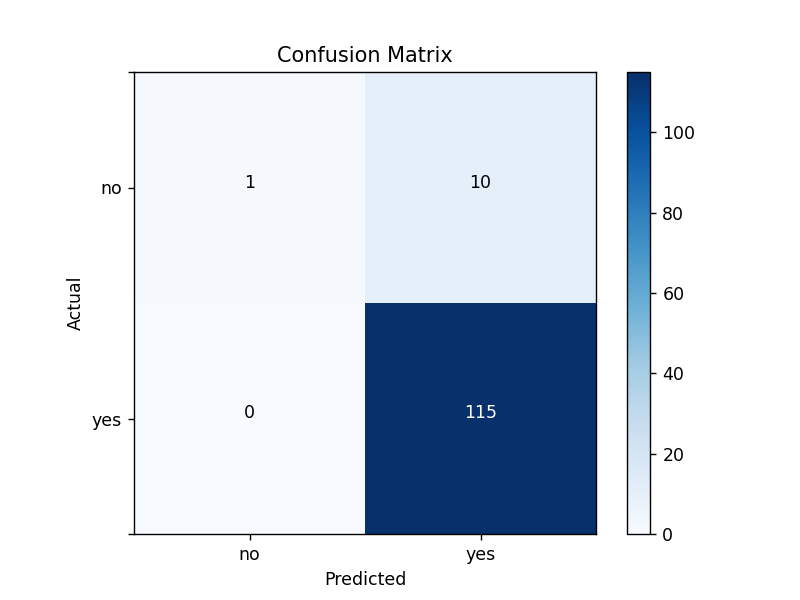

In [62]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(actual,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['no','yes']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','no','yes',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

### Retrieve the Best ONNX Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

Set the parameter return_onnx_model=True to retrieve the best ONNX model, instead of the Python model.

In [63]:
best_run, onnx_mdl = remote_run.get_output(return_onnx_model=True)

### Save the best ONNX model

In [64]:
from azureml.automl.runtime.onnx_convert import OnnxConverter
onnx_fl_path = "./best_model.onnx"
OnnxConverter.save_onnx_model(onnx_mdl, onnx_fl_path)

### Predict with the ONNX model, using onnxruntime package

In [65]:
import sys
import json
from azureml.automl.core.onnx_convert import OnnxConvertConstants
from azureml.train.automl import constants

if sys.version_info < OnnxConvertConstants.OnnxIncompatiblePythonVersion:
    python_version_compatible = True
else:
    python_version_compatible = False

import onnxruntime
from azureml.automl.runtime.onnx_convert import OnnxInferenceHelper

def get_onnx_res(run):
    res_path = 'onnx_resource.json'
    run.download_file(name=constants.MODEL_RESOURCE_PATH_ONNX, output_file_path=res_path)
    with open(res_path) as f:
        onnx_res = json.load(f)
    return onnx_res

if python_version_compatible:
    test_df = test_dataset.to_pandas_dataframe()
    mdl_bytes = onnx_mdl.SerializeToString()
    onnx_res = get_onnx_res(best_run)

    onnxrt_helper = OnnxInferenceHelper(mdl_bytes, onnx_res)
    pred_onnx, pred_prob_onnx = onnxrt_helper.predict(test_df)

    print(pred_onnx)
    print(pred_prob_onnx)
else:
    print('Please use Python version 3.6 or 3.7 to run the inference helper.')

[0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0
 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1
 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1
 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0]
[[0.8235725  0.17642748]
 [0.3442459  0.6557541 ]
 [0.36013746 0.63986254]
 [0.2980708  0.7019292 ]
 [0.38681418 0.6131858 ]
 [0.47550327 0.52449673]
 [0.6475679  0.35243207]
 [0.87664646 0.12335354]
 [0.4278518  0.5721482 ]
 [0.6989459  0.30105412]
 [0.41034383 0.5896562 ]
 [0.5266352  0.47336477]
 [0.23203415 0.76796585]
 [0.41205454 0.58794546]
 [0.26653075 0.73346925]
 [0.38342047 0.61657953]
 [0.32408315 0.67591685]
 [0.68813694 0.31186306]
 [0.39892995 0.60107005]
 [0.69109625 0.30890375]
 [0.52391106 0.47608894]
 [0.583733   0.41626698]
 [0.43104172 0.5689583 ]
 [0.5595332  0.44046682]
 [0.6819879  0.31801212]
 [0.46390778 0.5360922 ]
 [0.6095161  0.39048392]
 [0.7803638  0.2196362 ]
 [0.3954699  0.6045301 ]
 [0.19098836 0.809

### Delete a Web Service

Deletes the specified web service.

In [66]:
aci_service.delete()

**Delete the cluster at the end of the run**

In [71]:
compute_target.delete()

## Acknowledgements

This Las Vegas Trip Advisor dataset is available at: https://archive.ics.uci.edu/ml/datasets/Las+Vegas+Strip.

The dataset was generated by performing data mining on the reviews available on the Trip Advisor site between January and August of 2015 by Moro et al., 2017.

[Moro et al., 2017] Moro et al., 2017 (Moro, S., Rita, P., & Coelho, J. (2017). Stripping customers' feedback on hotels through data mining: The case of Las Vegas Strip. Tourism Management Perspectives, 23, 41-52.